<a href="https://colab.research.google.com/github/AdrianaUP/News-classifier_AGNews/blob/main/agnews_train_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --upgrade transformers datasets scikit-learn matplotlib seaborn pandas


In [2]:
from datasets import load_dataset

dataset = load_dataset("ag_news")

# Dividir en 70% train, 15% val, 15% test
base_split = dataset["train"].train_test_split(test_size=0.3, seed=42)
train_val = base_split["train"].train_test_split(test_size=0.1765, seed=42)  # 15% de total

train_dataset = train_val["train"]
val_dataset = train_val["test"]
test_dataset = base_split["test"]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"f1": f1_score(labels, preds, average="weighted")}

def train_model(model_name, train_dataset, val_dataset):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

    def tokenize(batch):
        return tokenizer(batch["text"], truncation=True, padding=True)

    train_dataset = train_dataset.map(tokenize, batched=True)
    val_dataset = val_dataset.map(tokenize, batched=True)

    train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    training_args = TrainingArguments(
        output_dir=f"./results/{model_name.replace('/', '_')}",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        logging_dir="./logs",
        logging_steps=10,
        evaluation_strategy="epoch"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    return trainer


In [4]:
models = {
    "RoBERTa": "roberta-base",
    "DeBERTa": "microsoft/deberta-v3-base",
    "ModernBERT": "bert-base-uncased"
}

trainers = {}
f1_scores = {}

for label, model_id in models.items():
    print(f"Entrenando {label}...")
    trainer = train_model(model_id, train_dataset, val_dataset)
    trainers[label] = trainer
    result = trainer.evaluate()
    f1_scores[label] = result["eval_f1"]


Entrenando RoBERTa...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/69174 [00:00<?, ? examples/s]

Map:   0%|          | 0/14826 [00:00<?, ? examples/s]

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

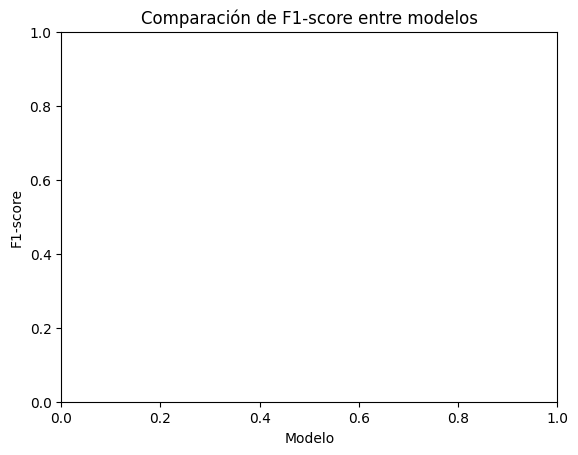

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()))
plt.title("Comparación de F1-score entre modelos")
plt.ylabel("F1-score")
plt.xlabel("Modelo")
plt.ylim(0, 1)
plt.show()
